# Convolutional networks
This file shows how to programm and setup a convolutional neural network using Tensorflow.
Steps to do:
	- download and import data
    - preprocess data (structure data into training, validation, test set etc)
    - create mini-batches of data for training
    - setup or import a neural network model (tf.Graph)
    - define loss function
    - train neural network
    - evaluate neural network
    - provide an inference function for predicting labels of test data set (unknown data)
    - visualize neural network data with tensorflow and here in jupyter notebook

In [1]:
import sys
sys.path.append('./util')
import time
import numpy as np
import pandas as pd
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt

import input_queues as iq
import cnn_model

print('Python version: \n' + sys.version)
print('Tensorflow version: \n' + tf.__version__)

# data path constants:
# DATA_DIR = '../data/mnist/'
DATA_DIR = 'data/'
PREDICT_PATH = ''
LOGS_PATH = 'logs/1/'  # path to summary files

# hyper-parameters:
m_height = 13  # multiplicate of image height size -> network is designed so that it can take images with shape of multiples of m
m_width = m_height  # multiplicate of image width size -> network is designed so that it can take images with shape of multiples of m
IMAGE_SHAPE = [32 * m_height, 32 * m_width, 3]  # complete image size [436, 1024, 3] # Narihira2015 use [M*32=13*32=416, 416, 3]
INITIAL_LEARNING_RATE = 1e-3
# probability that a neuron's output is kept during dropout (only during training!!!, testing/validation -> 1.0):
# DROPOUT_RATE = 0.5
BATCH_SIZE = 8  # nr of data which is put through the network before updating it, as default use: 32. 
# BATCH_SIZE determines how many data samples are loaded in the memory (be careful with memory space)
NUM_EPOCHS = 4  # nr of times the training process loops through the complete training data set (how often is the tr set 'seen')
# if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

DISPLAY_STEP = 4  # every DIPLAY_STEP'th training iteration information is printed (default: 100)
SUMMARY_STEP = 4  # every SUMMARY_STEP'th training iteration a summary file is written to LOGS_PATH
DEVICE = '/cpu:0'  # device on which the variable is saved/processed

Python version: 
3.6.0 (default, Dec 24 2016, 13:33:34) 
[GCC 4.2.1 Compatible Apple LLVM 8.0.0 (clang-800.0.42.1)]
Tensorflow version: 
1.1.0


## Importing Data and preprocessing:
	- (download and) import data
    - preprocess data (structure data into training, validation, test set etc)


In [2]:
with tf.name_scope('data'):
    # import training data set
    data_train = iq.SintelDataInputQueue(path_csv_file = DATA_DIR + 'sample_data_sintel_shading_train.csv',
                                         batch_size=BATCH_SIZE, num_epochs=NUM_EPOCHS, nr_data=None)
    # if data_augmentation=True: images are randomly rotated in range (-15, 15) deg and randomly horizontally flipped:
    image_path_batch_train, albedo_label_path_batch_train, shading_label_path_batch_train, \
        images_batch_train, labels_albedo_batch_train, labels_shading_batch_train = data_train.next_batch(image_shape=IMAGE_SHAPE, 
                                                                                                          data_augmentation=True)

    # import validation data set: 
    #     why not using the whole validation set for validation at once? 
    #     - limited memory space.
    #  -> After each training epoch we will use the complete validation data set to calculate the error/accuracy on the validation set
    data_valid = iq.SintelDataInputQueue(path_csv_file = DATA_DIR + 'sample_data_sintel_shading_valid.csv',
                                         batch_size=5, num_epochs=NUM_EPOCHS, nr_data=None)
    # if data_augmentation=True: images are randomly rotated in range (-15, 15) deg and randomly horizontally flipped:
    image_path_batch_valid, albedo_label_path_batch_valid, shading_label_path_batch_valid, \
        images_batch_valid, labels_albedo_batch_valid, labels_shading_batch_valid = data_valid.next_batch(image_shape=IMAGE_SHAPE, 
                                                                                                          data_augmentation=False)

    # testing data set: 
    data_test = iq.SintelDataInputQueue(path_csv_file = DATA_DIR + 'sample_data_sintel_shading_test.csv',
                                        batch_size=1, num_epochs=NUM_EPOCHS, nr_data=None)
    # if data_augmentation=True: images are randomly rotated in range (-15, 15) deg and randomly horizontally flipped:
    image_path_batch_test, albedo_label_path_batch_test, shading_label_path_batch_test, \
        images_batch_test, labels_albedo_batch_test, labels_shading_batch_test = data_test.next_batch(image_shape=IMAGE_SHAPE, 
                                                                                                      data_augmentation=False)
    
    # for the test set create also 
    image_path_test, albedo_label_path_test, shading_label_path_test = data_test.read_csv_file(record_defaults=[[''], [''], ['']])
    
    images_test = data_test.read_image(image_path=image_path_test)
    labels_albedo_test = data_test.read_image(image_path=albedo_label_path_test)
    labels_shading_test = data_test.read_image(image_path=shading_label_path_test)
    images_test, labels_albedo_test, labels_shading_test = data_test.random_crop_images_and_labels(image_and_labels=[images_test,
                                                                                                                     labels_albedo_test,
                                                                                                                     labels_shading_test],
                                                                                                   channels=[IMAGE_SHAPE[-1]]*3,
                                                                                                   spatial_shape=IMAGE_SHAPE[:2],
                                                                                                   data_augmentation=False)

In [3]:
def plot_images(images, titles='', *args, **kwargs):
    if isinstance(titles, str):
        titles = [titles] * len(images)
    for image, title in zip(images, titles):
        plt.figure(*args, **kwargs)
        plt.title(title)
        plt.imshow(image)

## Feed-forward setup:

In [4]:
# make sure we start with a new, empty graph before building it:
# tf.reset_default_graph()

# setup input placeholders with the shape of an image (28x28 pixel image
#     with 1 color channel; the first entry in shape corresponds to batch
#     size which is left variable here):
x = tf.placeholder(dtype=tf.float32, shape=[None] + IMAGE_SHAPE, name='input') 
# We want to create summaries that give us outputs (TensorFlow ops that output protocol buffers 
#      containing 'summarized' data) of images, e.g. to check right formating of input images (tf.summary.images())
#      display some input data in tensorboard under summary image:
#      (images are built from tensor which must be 4-D with shape [batch_size, height, width, channels]
#      where channels \elem {1 ->grayscale, 3 -> rgb, 4 -> rgba}. 
#      max_outputs: Max number of batch elements to generate images for)
tf.summary.image(name='input', tensor=x, max_outputs=3, collections=None)
# setup target output classes (ground truth):
y_albedo_ = tf.placeholder(dtype=tf.float32, shape=[None] + IMAGE_SHAPE, name='out_albedo')
y_shading_ = tf.placeholder(dtype=tf.float32, shape=[None] + IMAGE_SHAPE, name='out_shading')

# bool variable that indicates if we are in training mode (training=True) or valid/test mode (training=False)
# this indicator is important if dropout or/and batch normalization is used.
training = tf.placeholder(tf.bool)

In [5]:
# define model in a separate function:
y_albedo, y_shading = cnn_model.model(inputs=x, training=training, device=DEVICE)

Tensor("conv_s1-1/Relu:0", shape=(?, 104, 104, 96), dtype=float32)
Tensor("max_pool_s1-1:0", shape=(?, 52, 52, 96), dtype=float32)
Tensor("conv_s1-2/Relu:0", shape=(?, 52, 52, 256), dtype=float32)
Tensor("max_pool_s1-2:0", shape=(?, 26, 26, 256), dtype=float32)
Tensor("conv_s1-3/Relu:0", shape=(?, 26, 26, 256), dtype=float32)
Tensor("conv_s1-4/Relu:0", shape=(?, 26, 26, 384), dtype=float32)
Tensor("conv_s1-5/Relu:0", shape=(?, 26, 26, 256), dtype=float32)
Tensor("max_pool_s1-5:0", shape=(?, 13, 13, 256), dtype=float32)
Tensor("deconv_s1/BiasAdd:0", shape=(?, 104, 104, 256), dtype=float32)
Tensor("conv_s1-6/Relu:0", shape=(?, 104, 104, 64), dtype=float32)
Tensor("conv_s2-1/Relu:0", shape=(?, 208, 208, 96), dtype=float32)
Tensor("max_pool_s2-1:0", shape=(?, 104, 104, 96), dtype=float32)
Tensor("concat:0", shape=(?, 104, 104, 160), dtype=float32)
Tensor("conv_s2-2/Relu:0", shape=(?, 104, 104, 64), dtype=float32)
Tensor("conv_s2-3/Relu:0", shape=(?, 104, 104, 64), dtype=float32)
Tensor("co

## Loss & training:

In [6]:
# compute cross entropy as our loss function (it compares ground truth y_ to predictions y):
with tf.name_scope('loss'):
    mse_albedo = tf.reduce_mean(tf.square(y_albedo - y_albedo_))
    reduced_albedo = tf.square(tf.reduce_mean(y_albedo - y_albedo_))
    
    mse_shading = tf.reduce_mean(tf.square(y_shading - y_shading_))
    reduced_shading = tf.square(tf.reduce_mean(y_shading - y_shading_))
    
    # least square loss if lambda_ = 0, scale invariant loss if lambda_ = 1, 
    # average of both if lambda_ = 0.5:
    lambda_ = 0.5
    loss = (mse_albedo - lambda_ * reduced_albedo) + (mse_albedo - lambda_ * reduced_shading)
    # create summaries that give outputs (TensorFlow ops that output protocol buffers containing 
    #     'summarized' data) of some scalar parameters, like evolution of loss function
    #     (how does it change over time? / rather not weights 
    #     because there are usually several of them) etc (tf.summary.scalar())
    #     (have a look at parameters that change over time (= training steps))
    tf.summary.scalar(name='mean_squared_error', tensor=loss)


# Use an AdamOptimizer to train the network:
with tf.name_scope('optimization'):
    optimization_step = tf.train.AdamOptimizer(INITIAL_LEARNING_RATE).minimize(loss)


# # compute and display accuracy:
# with tf.name_scope('accuracy'):
#     # compares each prediction (y) and ground truth label (y_) with each other by 
#     #     looking on what position in the OHE the maximum argument is located (argmax),
#     #     returns True if they match:
#     correct_prediction = tf.equal(tf.argmax(input=y, axis=1, name=None, dimension=None), 
#                                   tf.argmax(input=y_, axis=1, name=None, dimension=None))
#     # number of true entries.
#     nr_correct = tf.reduce_sum(input_tensor=tf.cast(correct_prediction, tf.float32), 
#                                reduction_indices=None, keep_dims=False, name=None)
#     # calculate the mean over all dimensions:
#     accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32), 
#                               reduction_indices=None, keep_dims=False, name=None)
#     # create summaries that give outputs (TensorFlow ops that output protocol buffers 
#     #     containing 'summarized' data) of some scalar parameters, like evolution of 
#     #     accuracy (how does it change over time? / rather not weights 
#     #     because there are usually several of them) etc (tf.summary.scalar())
#     #     (have a look at parameters that change over time (= training steps))
#     tf.summary.scalar(name='accuracy', tensor=accuracy)

## Visualizing the graph and output parameters:
create summaries that give outputs (TensorFlow ops that output protocol buffers containing 'summarized' data) of
    - histogram summaries, that let us take a look at shape of distributions of parameters, like weights/biases (tf.summary.histogram())
    - tensor summaries for writing out any kind of value because everything in tensorflow is a tensor (tf.summary.tensor()) <- new/under development

In [7]:
# to get every summary defined above we merge them to get one target:
merge_train_summaries = tf.summary.merge_all()

# define a FileWriter op which writes summaries defined above to disk:
summary_writer = tf.summary.FileWriter(LOGS_PATH)

# Create a saver for writing training checkpoints.
saver = tf.train.Saver(max_to_keep=NUM_EPOCHS)

In [ ]:
# introduce some validation set specific summaries
#     These summaries need to be defined blow the function merge_train_summaries = tf.summary.merge_all()
#     because the validation set summaries are added to the summary writer at different times.
#     If they had been summarized with the training summaries they would have to be defined at times 
#     where merge_train_summaries are added to the summary writer
# with tf.name_scope('accuracy/'):  # '/' at the end means that the same name_scope as above should be used
#     valid_precision = tf.placeholder(dtype=tf.float32)
#     valid_precision_summary = tf.summary.scalar(name='validation_accuracy', tensor=valid_precision)
with tf.name_scope('loss/'):
    valid_loss = tf.placeholder(dtype=tf.float32)
    valid_loss_summary = tf.summary.scalar(name='validation_loss', tensor=valid_loss)

## Train the model:

In [ ]:
# Op that initializes global variables in the graph:
init_global = tf.global_variables_initializer()
# Op that initializes local variables in the graph:
init_local = tf.local_variables_initializer()

with tf.Session() as sess:
    
    ############################################################################
    # Initialization:
    # initialize all variables:
    sess.run([init_global, init_local])
    
    # Adds a Graph to the event file.
    #     create summary that give output (TensorFlow op that output protocol 
    #     buffers containing 'summarized' data) of the built Tensorflow graph:
    summary_writer.add_graph(sess.graph)
    
    # start timer for total training time:
    start_total_time = time.time()
    # set timer to measure the displayed training steps:
    start_time = start_total_time
    
    # Start populating the filename queue.
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    ############################################################################
    # Training:
    count_epoch = 0
    # train loop
    #     train for until all data is used
    #     number of iterations depends on number of data, number of epochs and 
    #     batch size:
    train_iters = int(data_train.nr_data / data_train.batch_size * data_train.num_epochs)
    print(f'For training it takes {train_iters} iterations to loop through ' +
          f'{data_train.nr_data} samples of training data over ' +
          f'{data_train.num_epochs} epochs summarized in batches of size ' +
          f'{data_train.batch_size}.\n' +
          f'So, there are {int(data_train.nr_data / data_train.batch_size)} ' + 
          f'iterations per epoch.\n')
    
    for i in range(1, train_iters + 1):
        # take a (mini) batch of the training data:
        #     method of the DataSet class        
        next_images_batch, next_labels_albedo_batch, \
            next_labels_shading_batch = sess.run([images_batch_train,
                                                  labels_albedo_batch_train, 
                                                  labels_shading_batch_train])
            
            
        # report training set accuracy at beginning:
        if i == 1:
            # console output:
            train_loss = sess.run(loss,
                                  feed_dict={x: next_images_batch,
                                             y_albedo_: next_labels_albedo_batch,
                                             y_shading_: next_labels_shading_batch,
                                             training: False})
            duration_time = time.time() - start_time
            print(f'step 0: training loss {train_loss:.2f} (ET: {duration_time:.2f} sec).')
            # reset timer to measure the displayed training steps:
            start_time = time.time()
        
        # run training/optimization step:
        #     Run one step of the model.  The return values are the activations
        #     from the `train_op` (which is discarded) and the `loss` Op.  To
        #     inspect the values of your Ops or variables, you may include them
        #     in the list passed to sess.run() and the value tensors will be
        #     returned in the tuple from the call.
        sess.run(optimization_step, feed_dict={x: next_images_batch,
                                               y_albedo_: next_labels_albedo_batch,
                                               y_shading_: next_labels_shading_batch,
                                               training: True})
        
        # report training set accuracy every DISPLAY_STEP-th step:
        if i % DISPLAY_STEP == 0:
            # console output:
            train_loss = sess.run(loss, 
                                  feed_dict={x: next_images_batch,
                                             y_albedo_: next_labels_albedo_batch,
                                             y_shading_: next_labels_shading_batch,
                                             training: False})
            duration_time = time.time() - start_time
            print(f'step {i}: training loss {train_loss:.2f} (ET: {duration_time:.2f} sec).')
            # reset timer to measure the displayed training steps:
            start_time = time.time()

        # display validation set accuracy and loss after each completed epoch 
        #     (1 epoch ^= data.nr_data / data.batch_size training steps
        #      => steps per epoch)
        if (i % int(data_train.nr_data / data_train.batch_size) == 0) and (i != 0):
            count_epoch += 1
            # save checkpoint files to disk:
            save_path = saver.save(sess, LOGS_PATH + 'model', global_step=i)
            print(f'Validation scores after epoch {count_epoch} (step {i}):\n' +
                  f'    Model saved in file: {save_path}.')
            # After each training epoch we will use the complete validation data
            #     set to calculate the error/accuracy on the validation set:
            # loop through one validation data set epoch:
            validation_loss = 0
            valid_steps_per_epoch = int(data_valid.nr_data / data_valid.batch_size)
            for j in range(valid_steps_per_epoch):
                # DISCLAIMER: we do not run the optimization_step here (on the 
                #     validation data set) because we do not want to train our 
                #     network on the validation set. Important for batch 
                #     normalization and dropout.
                # get validation data set (mini) batch:
                next_images_batch_valid, next_labels_albedo_batch_valid, \
                    next_labels_shading_batch_valid = sess.run([images_batch_valid, 
                                                                labels_albedo_batch_valid, 
                                                                labels_shading_batch_valid])
                
                # calculate the mean loss of this validation batch and sum it 
                #      with the previous mean batch losses:
                validation_loss += sess.run(loss, 
                                            feed_dict={x: next_images_batch_valid,
                                                       y_albedo_: next_labels_albedo_batch_valid,
                                                       y_shading_: next_labels_shading_batch_valid,
                                                       training: False})
            
            # adding a mean loss summary op (for tensorboard). 
            #     we need to divide the accumulated loss from above by the 
            #     iteration steps (steps_per_epoch):
            validation_loss_total = sess.run(valid_loss_summary, 
                                             feed_dict={valid_loss: validation_loss / valid_steps_per_epoch})
            summary_writer.add_summary(summary=validation_loss_total, 
                                       global_step=i)
            print(f'    Num validation data: {data_valid.nr_data}, num ' + 
                  f' mean loss: {validation_loss / valid_steps_per_epoch:.2f}')

        if i % SUMMARY_STEP == 0:
            s = sess.run(merge_train_summaries, feed_dict={x: next_images_batch, 
                                                           y_albedo_: next_labels_albedo_batch,
                                                           y_shading_: next_labels_shading_batch, 
                                                           training: False})
            # adds a Summary protocol buffer to the event file 
            #     (global_step: Number. Optional global step value to record 
            #     with the summary. Each stepp i is assigned to the 
            #     corresponding summary parameter.)
            summary_writer.add_summary(summary=s, global_step=i)
        
    
    end_total_time = time.time() - start_total_time
    duration_total_time_h = int(end_total_time // 3600)
    duration_total_time_min = int(end_total_time % 3600 // 60)
    duration_total_time_sec = int(end_total_time % 3600 % 60)
    print(f'\nTraining done... total training time: {duration_total_time_h}:' +
          f'{duration_total_time_min:02}:{duration_total_time_sec:02} h.')
    
    
#     ############################################################################
#     # Testing:
#     #     After training we will use the complete test data set to calculate the 
#     #     error/accuracy on the test set (this is useful if we run the model
#     #     on different hyper parameter (like learning rate/ weight 
#     #     initialization parameters, etc.) because then we can see their effect
#     #     on a data set that has never been seen by the training process):
#     print('\n\n\nTESTING:\n')
    
#     # define dataframe to save test results (same results which are also printed):
#     df_test_batch = pd.DataFrame(columns=['image_path', 'label', 'prediction', 'confidence'])

#     # loop through one test data set epoch:
#     test_true_count = 0  # Counts the number of correct predictions.
#     test_loss_count = 0
#     test_steps_per_epoch = int(data_test.nr_data / data_test.batch_size)
#     for j in range(test_steps_per_epoch):
#         # DISCLAIMER: we do not run the optimization_step here (on the test data 
#         #     set) because we do not want to train our network on the test set.
#         # get validation data set (mini) batch
#         next_image_batch_test, next_label_batch_test, next_image_path_batch_test = sess.run([image_batch_test, 
#                                                                                              label_batch_test,
#                                                                                              image_path_batch_test])
#         test_true_label, test_prediction, test_conf = sess.run([tf.argmax(input=y_, axis=1),
#                                                                 tf.argmax(input=tf.nn.softmax(y), axis=1),
#                                                                 tf.reduce_max(input_tensor=tf.nn.softmax(y))],
#                                                                feed_dict={x: next_image_batch_test, 
#                                                                           y_: next_label_batch_test,
#                                                                           training: False})
#         print(f'{next_image_path_batch_test[0]} label: {test_true_label[0]}, prediction: {test_prediction[0]} (conf: {test_conf:.2f})')
        
#         # append current test data point to dataframe:
#         df_test_batch = df_test_batch.append({'image_path': next_image_path_batch_test[0],
#                                               'label': test_true_label[0],
#                                               'prediction': test_prediction[0],
#                                               'confidence': test_conf}, ignore_index=True)
        
#         # calculate how many predicted labels match the ground truth label in 
#         #     this (mini) batch and add this number to the previous batch 
#         #     numbers:
#         test_true_count += sess.run(nr_correct, 
#                                     feed_dict={x: next_image_batch_test,
#                                                y_: next_label_batch_test,
#                                                training: False})
#         # calculate the mean loss of this validation batch and sum it with the 
#         #     previous mean batch losses:
#         test_loss_count += sess.run(loss, feed_dict={x: next_image_batch_test, 
#                                                      y_: next_label_batch_test,
#                                                      training: False})
#     print(f'\nFinally, results on the test set (not necessary here, but ' +
#           f'becomes necessary if one tries different hyperparameters like ' + 
#           f'learning rate):\nNum test data: {data_test.nr_data}, num ' +
#           f'correct: {test_true_count}, accuracy: ' +
#           f'{float(test_true_count) / data_test.nr_data:.3f}, mean loss: ' +
#           f'{test_loss_count / test_steps_per_epoch:.2f}\n\n')

#     # define dataframe to save test results (same results which are also printed):
#     df_test = pd.DataFrame(columns=['image_path', 'label', 'prediction', 'confidence'])

#     # This analysis of the test set is equivalent to the above.
#     # The difference is that this testing is (especially for small data sets)
#     # a bit more accurate. This is because if we use tf.train.shuffle_batch()
#     # we get duplicates over several different epochs, even if we just use 1 
#     # epoch.
#     # The downside of this method is that we need more evaluation time because
#     # we do not use batches, but feed every test data point step by step into 
#     # the network pipeline.
#     test_true_count = 0  # Counts the number of correct predictions.
#     test_loss_count = 0
#     for i in range(data_test.nr_data):
#         # Retrieve a single instance:
#         next_image_path_test, next_image_test, next_label_test, next_label_test_ohe = sess.run([image_path_test,
#                                                                                                 images_test, 
#                                                                                                 tf.argmax(input=labels_test),
#                                                                                                 labels_test])
#         # we need to reshape because we do not make a batch here and we need a 4D tensor
#         feed_dict = {x: next_image_test.reshape([1] + IMAGE_SHAPE),
#                      training: False}
#         prediction, confidence = sess.run([tf.argmax(input=tf.nn.softmax(y), axis=1),
#                                            tf.reduce_max(input_tensor=tf.nn.softmax(y))], feed_dict)
#         print(f'{next_image_path_test}, label: {next_label_test}, prediction: {prediction[0]} (confidence: {confidence:.2f})')
        
#         # append current test data point to dataframe:
#         df_test = df_test.append({'image_path': next_image_path_test,
#                                   'label': next_label_test,
#                                   'prediction': prediction[0],
#                                   'confidence': confidence}, ignore_index=True)

#         # calculate how many predicted labels match the ground truth label in 
#         #     this (mini) batch and add this number to the previous batch 
#         #     numbers:
#         # we need to reshape because we do not have a batch here
#         test_true_count += sess.run(nr_correct, 
#                                     feed_dict={x: next_image_test.reshape([1] + IMAGE_SHAPE),
#                                                y_: next_label_test_ohe.reshape([1,10]),
#                                                training: False})
#         # calculate the mean loss of this validation batch and sum it with the 
#         #     previous mean batch losses:
#         test_loss_count += sess.run(loss, feed_dict={x: next_image_test.reshape([1] + IMAGE_SHAPE), 
#                                                      y_: next_label_test_ohe.reshape([1,10]),
#                                                      training: False})
#     print(f'\nFinally, results on the test set (not necessary here, but ' +
#           f'becomes necessary if one tries different hyperparameters like ' + 
#           f'learning rate):\nNum test data: {data_test.nr_data}, num ' +
#           f'correct: {test_true_count}, accuracy: ' +
#           f'{float(test_true_count) / data_test.nr_data:.3f}, mean loss: ' +
#           f'{test_loss_count / test_steps_per_epoch:.2f}')
   

#     ############################################################################
#     # Predictions on single images:
#     print('\n\n\nPREDICTIONS:\n')
#     img_pred = plt.imread(PREDICT_PATH + '2.png').reshape([1] + IMAGE_SHAPE)
#     feed_dict = {x: img_pred,
#                  training: False}
#     prediction, confidence, conf_total = sess.run([tf.argmax(input=tf.nn.softmax(y), axis=1), 
#                                                    tf.reduce_max(input_tensor=tf.nn.softmax(y)),
#                                                    tf.nn.softmax(y)],
#                                                   feed_dict)
#     plt.imshow(img_pred.reshape(28,28), cmap='Greys')

#     print(f'prediction: {prediction[0]} (confidence: {confidence:.2f})')
#     print(f'confidence for all labels: {conf_total}')
    
    ############################################################################
    coord.request_stop()
    coord.join(threads)

For training it takes 25 iterations to loop through 50 samples of training data over 4 epochs summarized in batches of size 8.
So, there are 6 iterations per epoch.

step 0: training loss 0.18 (ET: 38.17 sec).
step 4: training loss -0.01 (ET: 293.78 sec).
Validation scores after epoch 1 (step 6):
    Model saved in file: logs/1/model-6.
    Num validation data: 20, num  mean loss: -0.41
step 8: training loss 2.14 (ET: 470.05 sec).


In [ ]:
with tf.Session() as sess:

random number generator result: 0


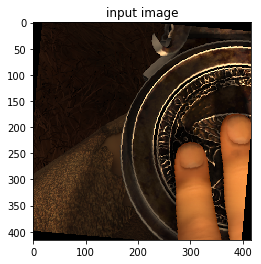

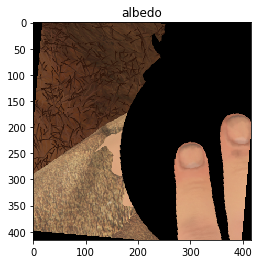

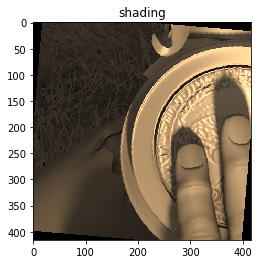

In [22]:
k = np.random.randint(low=0, high=1)
print(f'random number generator result: {k}')
# print(f'path to (raw) image: {next_image_path_batch[k]}')
plot_images(images=[next_images_batch[k],
                    next_labels_albedo_batch[k],
                    next_labels_shading_batch[k]],
            titles=['input image', 'albedo', 'shading'])

In [16]:
# # only show wrong predictions:
# df_test[df_test['label']!=df_test['prediction']]

,image_path,label,prediction,confidence
39,b'../data/mnist/test/0/1375_0.png',0,9,1.000000
74,b'../data/mnist/test/0/17448_0.png',0,8,1.000000
92,b'../data/mnist/test/0/19555_0.png',0,9,0.592070
163,b'../data/mnist/test/0/26349_0.png',0,9,1.000000
218,b'../data/mnist/test/0/3084_0.png',0,9,1.000000
319,b'../data/mnist/test/0/39241_0.png',0,4,1.000000
342,b'../data/mnist/test/0/4097_0.png',0,8,1.000000
381,b'../data/mnist/test/0/5885_0.png',0,9,0.995203
391,b'../data/mnist/test/0/6543_0.png',0,8,1.000000
451,b'../data/mnist/test/1/11246_1.png',1,9,0.985727


## open tensorboard:

In [25]:
!tensorboard --logdir ../data/mnist/logs/4

Starting TensorBoard b'47' at http://0.0.0.0:6006
(Press CTRL+C to quit)
^C
